In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import census
import us
from scipy import stats
warnings.simplefilter("ignore") 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from tqdm import tqdm
from itertools import combinations, chain

In [2]:
parkvars=gpd.read_file('S:/376/Spring22/jkchap16/accessibility_vars.shp')
parkvars['parkx']=parkvars.geometry.centroid.x
parkvars['parky']=parkvars.geometry.centroid.y
parkvars.head()

,park_subse,feat_code,landuse,park_name,parknum,shape_area,shape_leng,source_id,status,sub_code,...,fountain_c,athletic_c,percent_wi,percent_ga,walk2park_,percent_wa,subway_min,geometry,parkx,parky
0,0,4910.0,Community Park,Commodore Barry Park,B021,4.153980e+04,829.420107,2.149100e+10,Updated,491050.0,...,1.0,4.0,1.0,1.0,6720.752610,101.000000,798.440640,"POLYGON ((-8235329.517 4967898.091, -8235332.6...",-8.235378e+06,4.967873e+06
1,1,4980.0,Neighborhood Park,Pierrepont Playground,B222,2.196049e+04,607.555193,2.149800e+10,Unchanged,498000.0,...,4.0,1.0,1.0,1.0,3439.637878,97.813803,495.166635,"POLYGON ((-8237344.014 4967605.736, -8237344.2...",-8.237371e+06,4.967644e+06
2,2,4980.0,Neighborhood Park,Cobble Hill Park,B326,2.807908e+04,784.421990,2.149800e+10,Unchanged,498000.0,...,3.0,1.0,1.0,1.0,4153.542221,92.454923,599.082879,"POLYGON ((-8237149.641 4966419.691, -8237149.6...",-8.237196e+06,4.966461e+06
3,3,4980.0,Community Park,Commodore Barry Park,B021,4.384161e+05,2672.710150,2.149800e+10,Unchanged,498000.0,...,8.0,19.0,1.0,1.0,70659.887205,100.618441,766.677337,"POLYGON ((-8235133.914 4967679.410, -8235133.3...",-8.235298e+06,4.967795e+06
4,10,4980.0,Community Park,Brooklyn Bridge Park,B431,1.995609e+06,18025.160510,2.149800e+10,Updated,498000.0,...,7.0,19.0,1.0,1.0,315581.740275,98.741634,472.344407,"POLYGON ((-8237031.726 4968770.973, -8237031.7...",-8.237513e+06,4.967910e+06


In [3]:
nyc_acs=pd.read_csv('S:/376/Spring22/jkchap16/nyc_acs.csv')
nyc_acs['GEOID']=nyc_acs['GEOID'].astype('str')

In [4]:
tracts=gpd.read_file('S:/376/Spring22/jkchap16/nyc_tract.zip')
tracts.to_crs(epsg='3857', inplace=True)
tracts['tractx']=tracts.geometry.centroid.x
tracts['tracty']=tracts.geometry.centroid.y

In [5]:
# the county codes are 
codes={'manhattan':'061', 'staten_island':'085','bronx':'005', 'queens':'081', 'brooklyn':'047'}
stat_tracts=tracts[tracts['COUNTYFP']=='061']

In [6]:
stat_parkvars=gpd.sjoin(parkvars, stat_tracts, op='intersects')

In [7]:
A_euclid = []
for i in tqdm(range(len(stat_tracts)), position=0):
    xo = stat_tracts['tractx'].iloc[i]
    yo = stat_tracts['tracty'].iloc[i]
    Ai_euclid = 0
    for j in range(len(stat_parkvars)):
        xd = stat_parkvars['parkx'].iloc[j]
        yd = stat_parkvars['parky'].iloc[j]
        a = np.array((xo, yo))
        b = np.array((xd, yd))
        euclid_dist= np.linalg.norm(a-b)
        if euclid_dist > 0:
            Ai_euclid  += (stat_parkvars['park_area'].iloc[j] * stat_parkvars['avg_ndvi'].iloc[j]* stat_parkvars['cpa_count'].iloc[j]* 
                           stat_parkvars['fountain_c'].iloc[j]* stat_parkvars['athletic_c'].iloc[j]* stat_parkvars['percent_wi'].iloc[j]* 
                           stat_parkvars['percent_ga'].iloc[j]* stat_parkvars['percent_wa'].iloc[j]* stat_parkvars['subway_min'].iloc[j])/euclid_dist
                           
                    
            
    A_euclid.append(Ai_euclid)
    
stat_tracts['A_euclid']=A_euclid
stat_tracts    
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:13<00:00, 22.50it/s]


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tractx,tracty,A_euclid
45,36,061,012700,36061012700,127,Census Tract 127,G5020,S,174025,0,+40.7622370,-073.9898561,"POLYGON ((-8236880.448 4977418.305, -8236829.7...",-8.236513e+06,4.977335e+06,5.793086e+12
46,36,061,012800,36061012800,128,Census Tract 128,G5020,S,178794,0,+40.7713809,-073.9615172,"POLYGON ((-8233670.328 4978537.856, -8233615.2...",-8.233358e+06,4.978679e+06,1.067669e+13
47,36,061,013000,36061013000,130,Census Tract 130,G5020,S,178225,0,+40.7727364,-073.9647332,"POLYGON ((-8234028.220 4978736.734, -8233973.1...",-8.233716e+06,4.978878e+06,1.209871e+13
48,36,061,013300,36061013300,133,Census Tract 133,G5020,S,174355,0,+40.7647381,-073.9880352,"POLYGON ((-8236677.513 4977786.330, -8236626.6...",-8.236310e+06,4.977702e+06,6.276648e+12
49,36,061,013400,36061013400,134,Census Tract 134,G5020,S,181768,0,+40.7717015,-073.9561657,"POLYGON ((-8233098.480 4978725.121, -8233046.7...",-8.232763e+06,4.978726e+06,9.862509e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,36,061,025700,36061025700,257,Census Tract 257,G5020,S,144062,0,+40.8084355,-073.9540741,"POLYGON ((-8232833.985 4983996.053, -8232782.5...",-8.232530e+06,4.984127e+06,1.212573e+13
4894,36,061,024200,36061024200,242,Census Tract 242,G5020,S,347358,135919,+40.8058563,-073.9335113,"POLYGON ((-8230750.418 4983820.598, -8230699.9...",-8.230238e+06,4.983743e+06,7.184062e+12
4895,36,061,008603,36061008603,86.03,Census Tract 86.03,G5020,S,116894,153941,+40.7548017,-073.9634783,"POLYGON ((-8233985.251 4975943.110, -8233972.6...",-8.233511e+06,4.976002e+06,5.340521e+12
5404,36,061,016900,36061016900,169,Census Tract 169,G5020,S,180003,0,+40.7851959,-073.9731196,"POLYGON ((-8235019.520 4980788.810, -8234967.9...",-8.234650e+06,4.980710e+06,1.838543e+13


In [8]:
stat_tracts_acs=stat_tracts.merge(nyc_acs, on='GEOID')
stat_tracts_acs.fillna(0, inplace=True)

In [9]:
nyc_acs.columns

Index(['Unnamed: 0', 'name', 'total', 'nhwhite', 'nhblack', 'nhindian',
       'nhasian', 'nhislander', 'latino', 'med_income', 'poverty',
       'hs_diploma', 'college_diploma', 'unemployed', 'med_age', 'noncitizen',
       'SNAP', 'state', 'county', 'tract', 'GEOID', 'percent_white',
       'percent_black', 'percent_asian', 'percent_latino', 'percent_poverty',
       'percent_hsdiploma', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_SNAP',
       'percent_noncitizen'],
      dtype='object')

In [12]:
demos = stat_tracts_acs[['percent_black','percent_asian', 'percent_latino','percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income' ]]
cols = [demo for demo in demos.columns]

Y = stat_tracts_acs['A_euclid']

rsq_vals = {}

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

for i, combo in enumerate(powerset(demos), 1):
    X = demos[list(combo)]
    X=sm.add_constant(X)
    model=sm.OLS(Y,X, missing = 'drop').fit()
    rsq_vals[combo]= model.rsquared

key_max = max(rsq_vals, key=rsq_vals.get)

print(f'Best variables {key_max} for a R-value of {round(rsq_vals[key_max], 5)}')

Best variables ('percent_black', 'percent_asian', 'percent_latino', 'percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income') for a R-value of 0.50325


In [37]:
demos = stat_tracts_acs[['percent_black','percent_asian', 'percent_latino', 'percent_unemployed', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_noncitizen', 'med_age', 'percent_hsdiploma']]

In [47]:
df = pd.DataFrame(np.random.randint(10, size=(5,3)), columns=list('abc'))

c = demos.corr()
c[c >= 0.5].stack().reset_index(name='cor').query("abs(cor) < 1.0")

,level_0,level_1,cor
1,percent_black,percent_hsdiploma,0.558642
4,percent_latino,percent_hsdiploma,0.616415
14,percent_hsdiploma,percent_black,0.558642
15,percent_hsdiploma,percent_latino,0.616415


In [14]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset)

In [15]:
correlation(demos, .5)

     percent_black  percent_asian  percent_latino  percent_college_diploma  \
0         4.070374      11.555092       23.244372                44.013717   
1         0.222883       2.878900       10.326895                26.653046   
2         0.603500       4.345202        5.461678                23.868437   
3         4.640334      26.814387       22.174053                37.395633   
4         4.709507       9.445423        3.397887                30.765845   
..             ...            ...             ...                      ...   
267      39.978378       6.162162       16.043243                25.102703   
268      55.146912       2.298621       37.957226                 8.235059   
269       0.409091      10.181818       10.613636                33.295455   
270       0.680597      10.173134       12.083582                33.205970   
271      22.544822      18.450629       47.163500                12.777629   

     percent_indian  percent_islander  percent_noncitizen  med_

In [39]:
demos = stat_tracts_acs[['percent_black','percent_asian', 'percent_latino', 'percent_unemployed', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_noncitizen', 'med_age', 'percent_hsdiploma' ]]

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = sm.add_constant(demos) 
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                      16.900937
percent_black               1.512095
percent_asian               1.244290
percent_college_diploma     1.375783
percent_unemployed          1.266209
percent_indian              1.013574
percent_islander            1.009797
percent_noncitizen          1.260757
dtype: float64

In [40]:
X = sm.add_constant(demos) 
 
model = sm.OLS(Y, X).fit()
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               A_euclid   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     22.24
Date:                Fri, 17 Jun 2022   Prob (F-statistic):           7.11e-30
Time:                        13:25:16   Log-Likelihood:                -9291.5
No. Observations:                 272   AIC:                         1.860e+04
Df Residuals:                     261   BIC:                         1.864e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

# For the whole city...

In [26]:
A_euclid = []
for i in tqdm(range(len(tracts)), position=0):
    xo = tracts.tractx.iloc[i]
    yo = tracts.tracty.iloc[i]
    Ai_euclid = 0
    for j in range(len(parkvars)):
        xd = parkvars.parkx.iloc[j]
        yd = parkvars.parky.iloc[j]
        a = np.array((xo, yo))
        b = np.array((xd, yd))
        euclid_dist=np.linalg.norm(a-b)
        if euclid_dist > 0:
            Ai_euclid  += (parkvars['park_area'].iloc[j] * parkvars['avg_ndvi'].iloc[j]* parkvars['cpa_count'].iloc[j]* 
                           parkvars['fountain_c'].iloc[j]* parkvars['athletic_c'].iloc[j]* parkvars['percent_wi'].iloc[j]* 
                           parkvars['percent_ga'].iloc[j]* parkvars['percent_wa'].iloc[j]* parkvars['subway_min'].iloc[j])/euclid_dist
                           
                    
            
    A_euclid.append(Ai_euclid)

tracts['A_euclid']=A_euclid
tracts.head()

100%|██████████████████████████████████████████████████████████████████████████████| 5411/5411 [23:11<00:00,  3.89it/s]


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tractx,tracty,A_euclid
0,36,047,069601,36047069601,696.01,Census Tract 696.01,G5020,S,456923,47776,+40.6271699,-073.9153676,"POLYGON ((-8228581.357 4958226.427, -8228394.1...",-8.228156e+06,4.957512e+06,3.463560e+13
1,36,047,069602,36047069602,696.02,Census Tract 696.02,G5020,S,688168,172866,+40.6227610,-073.9092489,"POLYGON ((-8228455.121 4956674.193, -8228401.7...",-8.227473e+06,4.956853e+06,3.623868e+13
2,36,047,079801,36047079801,798.01,Census Tract 798.01,G5020,S,129680,0,+40.6600109,-073.9587186,"POLYGON ((-8233275.255 4962574.814, -8232860.4...",-8.233047e+06,4.962322e+06,3.358027e+13
3,36,047,079802,36047079802,798.02,Census Tract 798.02,G5020,S,106366,0,+40.6579906,-073.9613711,"POLYGON ((-8233502.792 4962394.314, -8233412.7...",-8.233342e+06,4.962026e+06,3.436682e+13
4,36,047,105801,36047105801,1058.01,Census Tract 1058.01,G5020,S,418443,0,+40.6492205,-073.8805957,"POLYGON ((-8224896.794 4961306.249, -8224843.0...",-8.224350e+06,4.960739e+06,3.146352e+13


In [28]:
tracts_acs=tracts.merge(nyc_acs, on='GEOID')
tracts_acs.fillna(0, inplace=True)

In [21]:
demos = tracts_acs[['percent_black','percent_asian', 'percent_latino','percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income' ]]
cols = [demo for demo in demos.columns]

Y = tracts_acs['A_euclid']

rsq_vals = {}

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

for i, combo in enumerate(powerset(demos), 1):
    X = demos[list(combo)]
    X=sm.add_constant(X)
    model=sm.OLS(Y,X, missing = 'drop').fit()
    rsq_vals[combo]= model.rsquared

key_max = max(rsq_vals, key=rsq_vals.get)

print(f'Best variables {key_max} for a R-value of {round(rsq_vals[key_max], 5)}')

Best variables ('percent_black', 'percent_asian', 'percent_latino', 'percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income') for a R-value of 0.09702


In [48]:
x=tracts_acs[['percent_black','percent_asian', 'percent_indian', 'percent_islander', 'percent_college_diploma', 'percent_unemployed', 
    'percent_noncitizen']]
y=tracts_acs[['A_euclid']]

In [49]:
X = sm.add_constant(x) 
 
model = sm.OLS(y, X).fit()
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               A_euclid   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.257
Date:                Fri, 17 Jun 2022   Prob (F-statistic):             0.0274
Time:                        14:58:47   Log-Likelihood:                -68172.
No. Observations:                2036   AIC:                         1.364e+05
Df Residuals:                    2028   BIC:                         1.364e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

In [53]:
variables= tracts_acs[['A_euclid', 'percent_black','percent_asian', 'percent_latino','percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income' ]]

In [52]:
for i in variables.columns:
    print(i)

percent_black
percent_asian
percent_latino
percent_poverty
percent_unemployed
percent_college_diploma
percent_unemployed
percent_indian
percent_islander
percent_SNAP
percent_noncitizen
med_age
percent_hsdiploma
med_income


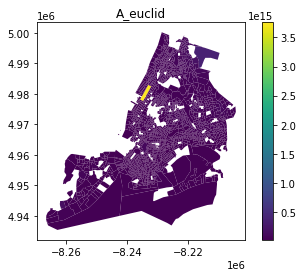

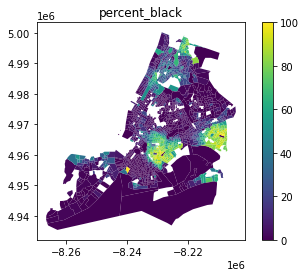

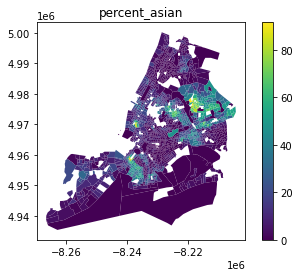

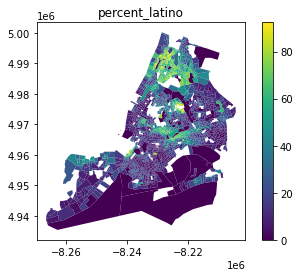

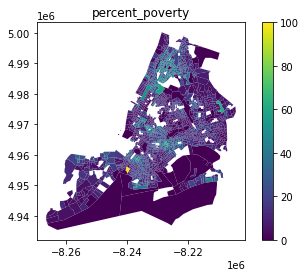

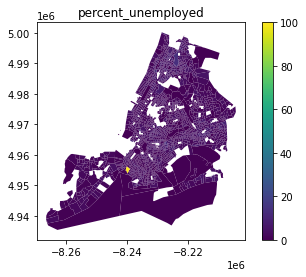

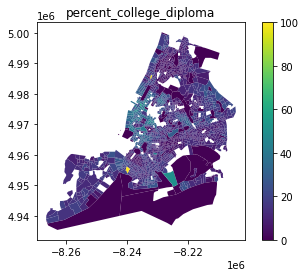

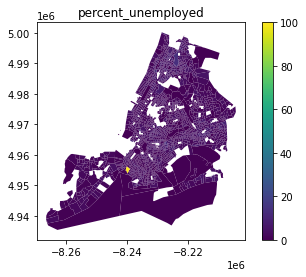

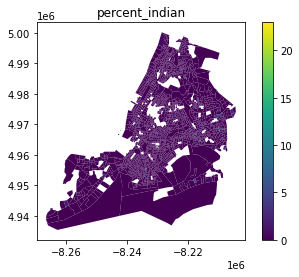

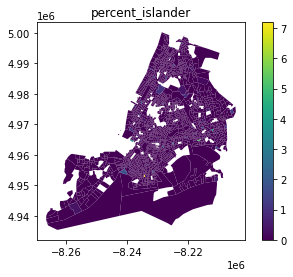

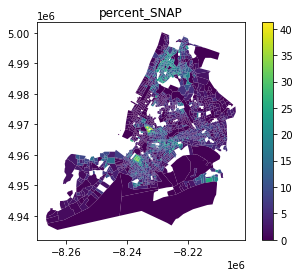

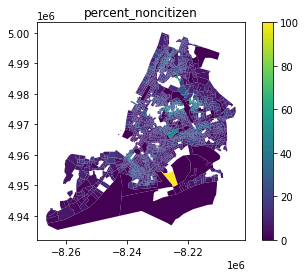

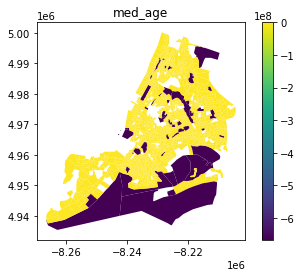

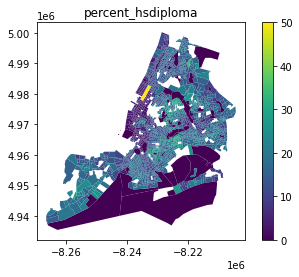

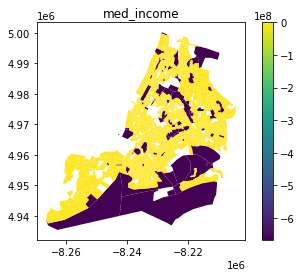

In [56]:
for i in variables.columns:
    tracts_acs.plot(column=i, cmap='viridis', legend=True)
    plt.title(i)
    plt.show()

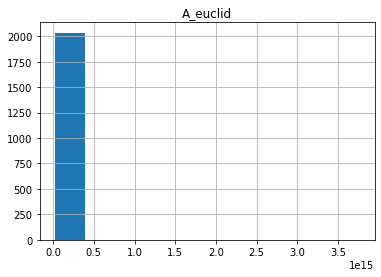

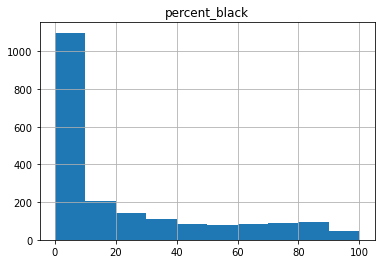

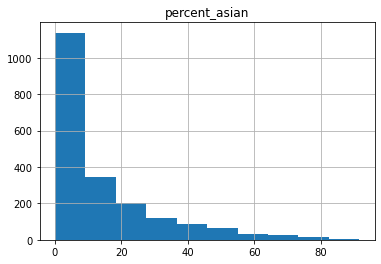

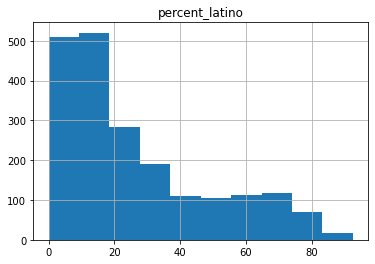

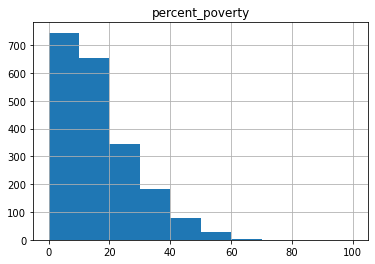

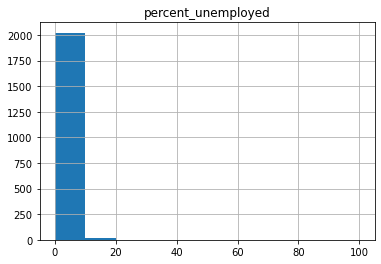

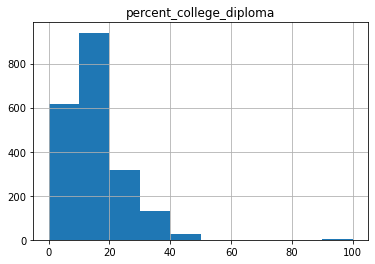

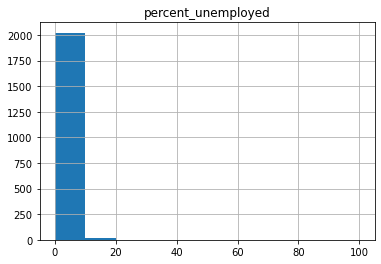

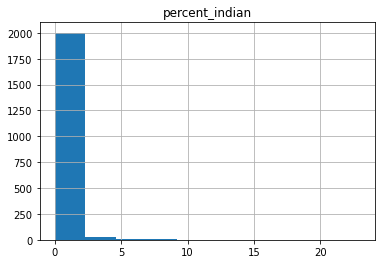

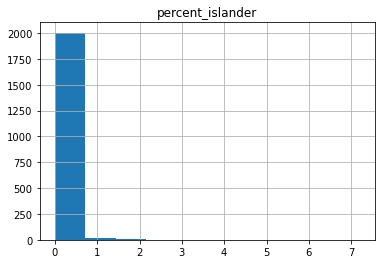

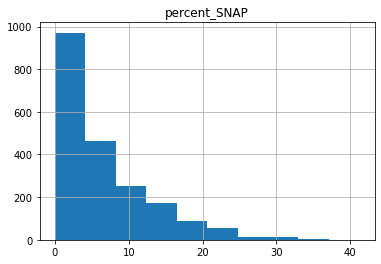

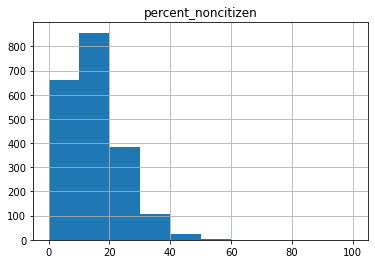

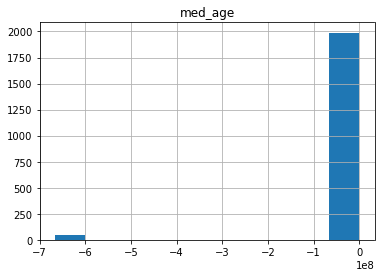

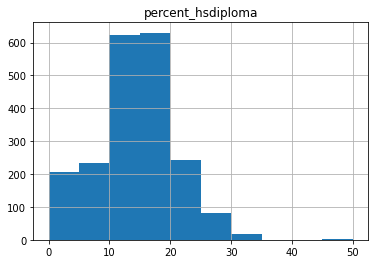

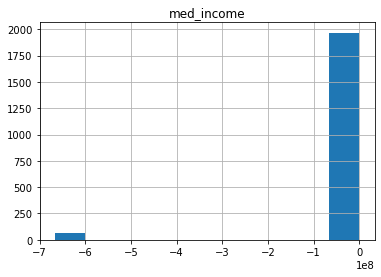

In [57]:
for i in variables.columns:
    tracts_acs.hist(column=i)

In [ ]:
#https://stackoverflow.com/questions/67779818/finding-all-the-variables-that-give-the-highest-adjusted-r-squared-value

In [ ]:
#https://stats.stackexchange.com/questions/253334/how-to-solve-multicollinearity-problem-in-a-linear-regression
#https://stats.stackexchange.com/questions/51473/matrix-is-not-positive-definite-even-when-highly-correlated-variables-are-re/251050#251050
#https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
#https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
#https://stackoverflow.com/questions/33568083/detecting-highly-correlated-attributes